In [1]:
# ============================== Import Libraries ==============================================================================================================================================================================
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
import statsmodels.api as sm
from scipy.stats import chi2
from numpy import linalg as LA
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse
import statsmodels.tsa.holtwinters as ets
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import STL, seasonal_decompose
import warnings
from datetime import datetime
import sys
sys.path.append('../toolbox')
from toolbox import autocorr, autocorr_values,ADF_Cal,Cal_GPAC, Cal_GPAC_DataFrame, ACF_PACF_Plot,Rolling_Mean_Var_Plot, difference, Q_value, LMA, A_Cal

# Ignore warnings
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd
import numpy as np

# Load CSV
df = pd.read_csv(r'B:\SRIP\Project\Weather_data\data_200\1992-2022_5.csv')  # replace with your actual file path

# Create datetime column
df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
tl = df['TL']
# Create TL time series
tl_series = pd.Series(data=df['TL'].values, index=df['datetime'], name='TL')

# Optional: print or inspect
print(tl_series.head())
print(tl.head())

datetime
1992-01-01 00:00:00   -0.0000
1992-01-01 01:00:00   -0.0000
1992-01-01 02:00:00   -0.0372
1992-01-01 03:00:00   -0.1104
1992-01-01 04:00:00   -0.2256
Name: TL, dtype: float64
0   -0.0000
1   -0.0000
2   -0.0372
3   -0.1104
4   -0.2256
Name: TL, dtype: float64


                                      SARIMAX Results                                       
Dep. Variable:                                   TL   No. Observations:                 4000
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 24)   Log Likelihood               -4906.877
Date:                              Tue, 20 May 2025   AIC                           9823.754
Time:                                      14:13:29   BIC                           9855.160
Sample:                                  06-06-2022   HQIC                          9834.894
                                       - 11-20-2022                                         
Covariance Type:                             approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4958      0.017     29.888      0.000       0.463       0.528
ar.L2         -0.02

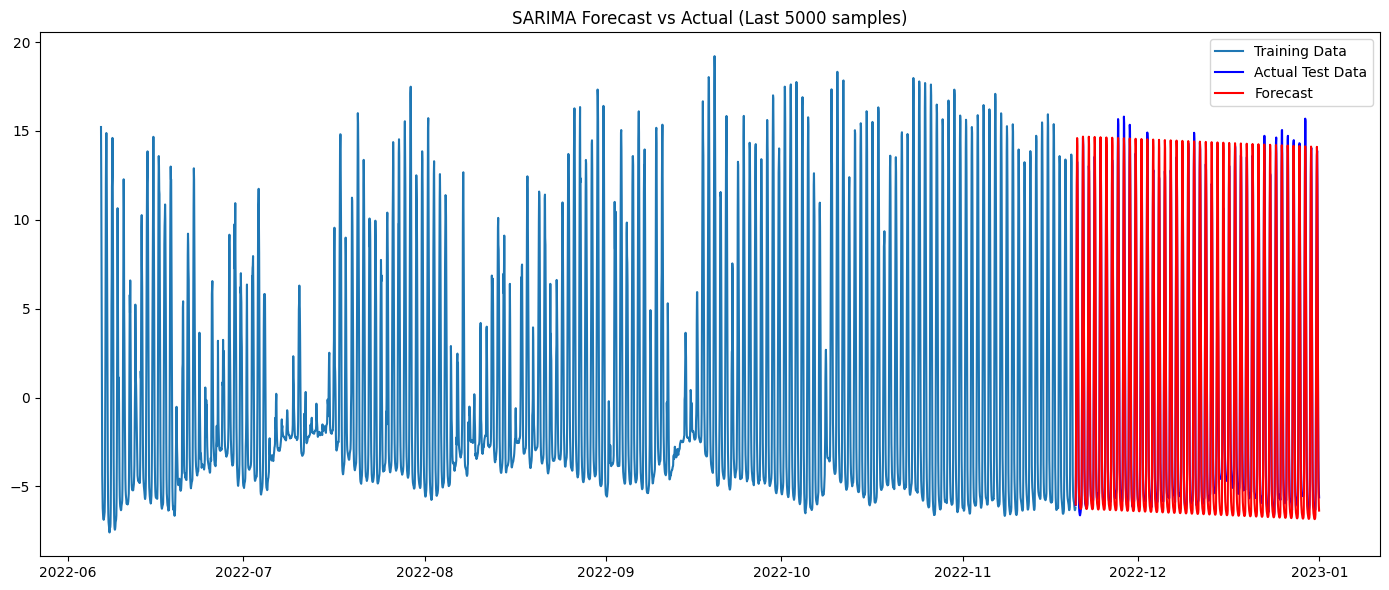

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

# Trim the series for memory efficiency
tl_series_small = tl_series[-5000:]

# Split into 80% train and 20% test
train_size = int(len(tl_series_small) * 0.8)
train, test = tl_series_small[:train_size], tl_series_small[train_size:]

# Fit SARIMA model on training data
model = SARIMAX(train,
                order=(2, 1, 0),
                seasonal_order=(1, 1, 1, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False, low_memory=True)

# Summary
print(results.summary())

# Forecast for the length of the test set
n_test = len(test)
forecast = results.get_forecast(steps=n_test)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title('SARIMA Forecast vs Actual (Last 5000 samples)')
plt.legend()
plt.tight_layout()
plt.show()


# ======================= Description of Dataset ================================================================================================= #
Number of row: 271752
Number of column: 11
Independent Variables:
 ['Year', 'Month', 'Day', 'Hour', 'AirTemp', 'Wind', 'Tdp', 'TL', 'CESR', 'datetime']
Dependent Variable: Solar



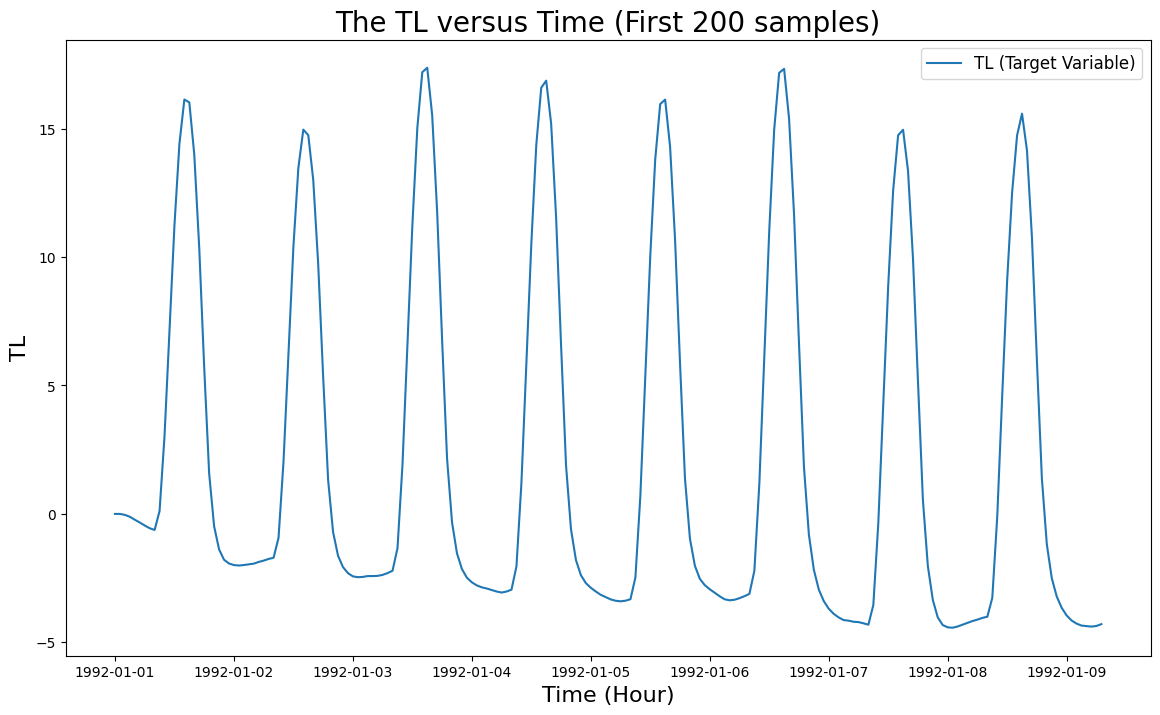

In [3]:
import matplotlib.pyplot as plt

print('# ======================= Description of Dataset ================================================================================================= #')
print('Number of row:', df.shape[0])
print('Number of column:', df.shape[1])
print('Independent Variables:\n', df.columns[:7].tolist() + df.columns[8:].tolist())
print('Dependent Variable:', df.columns[7])
print()

# a. Plot the dependent variable (TL) versus time (first 200 samples)
plt.figure(figsize=(14,8))
plt.plot(df['datetime'][:200], df['TL'][:200], label='TL (Target Variable)')
plt.legend(fontsize=12)
plt.xlabel('Time (Hour)', fontsize=16)
plt.ylabel('TL', fontsize=16)
plt.title('The TL versus Time (First 200 samples)', fontsize=20)
plt.show()

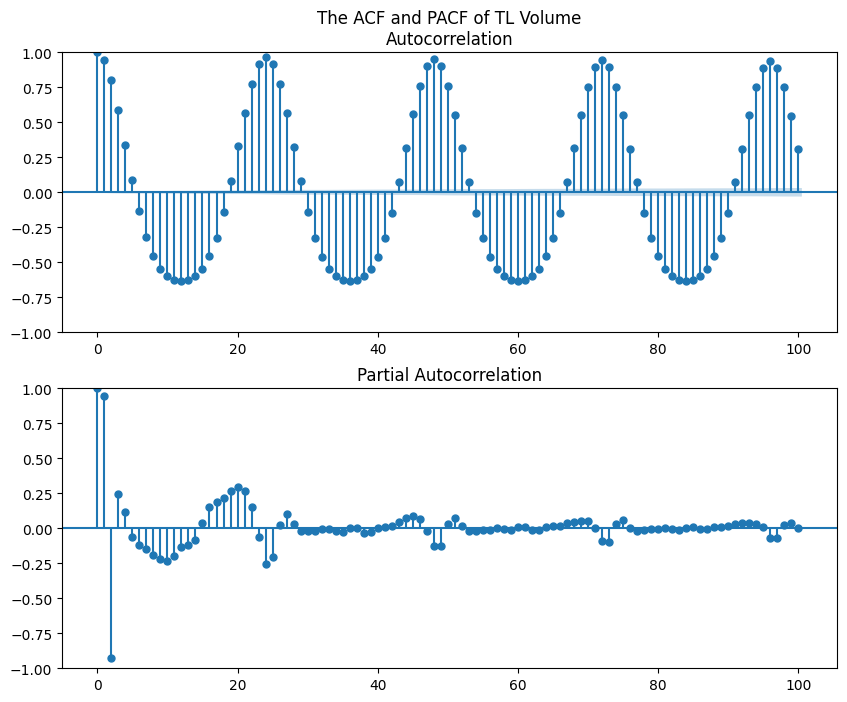

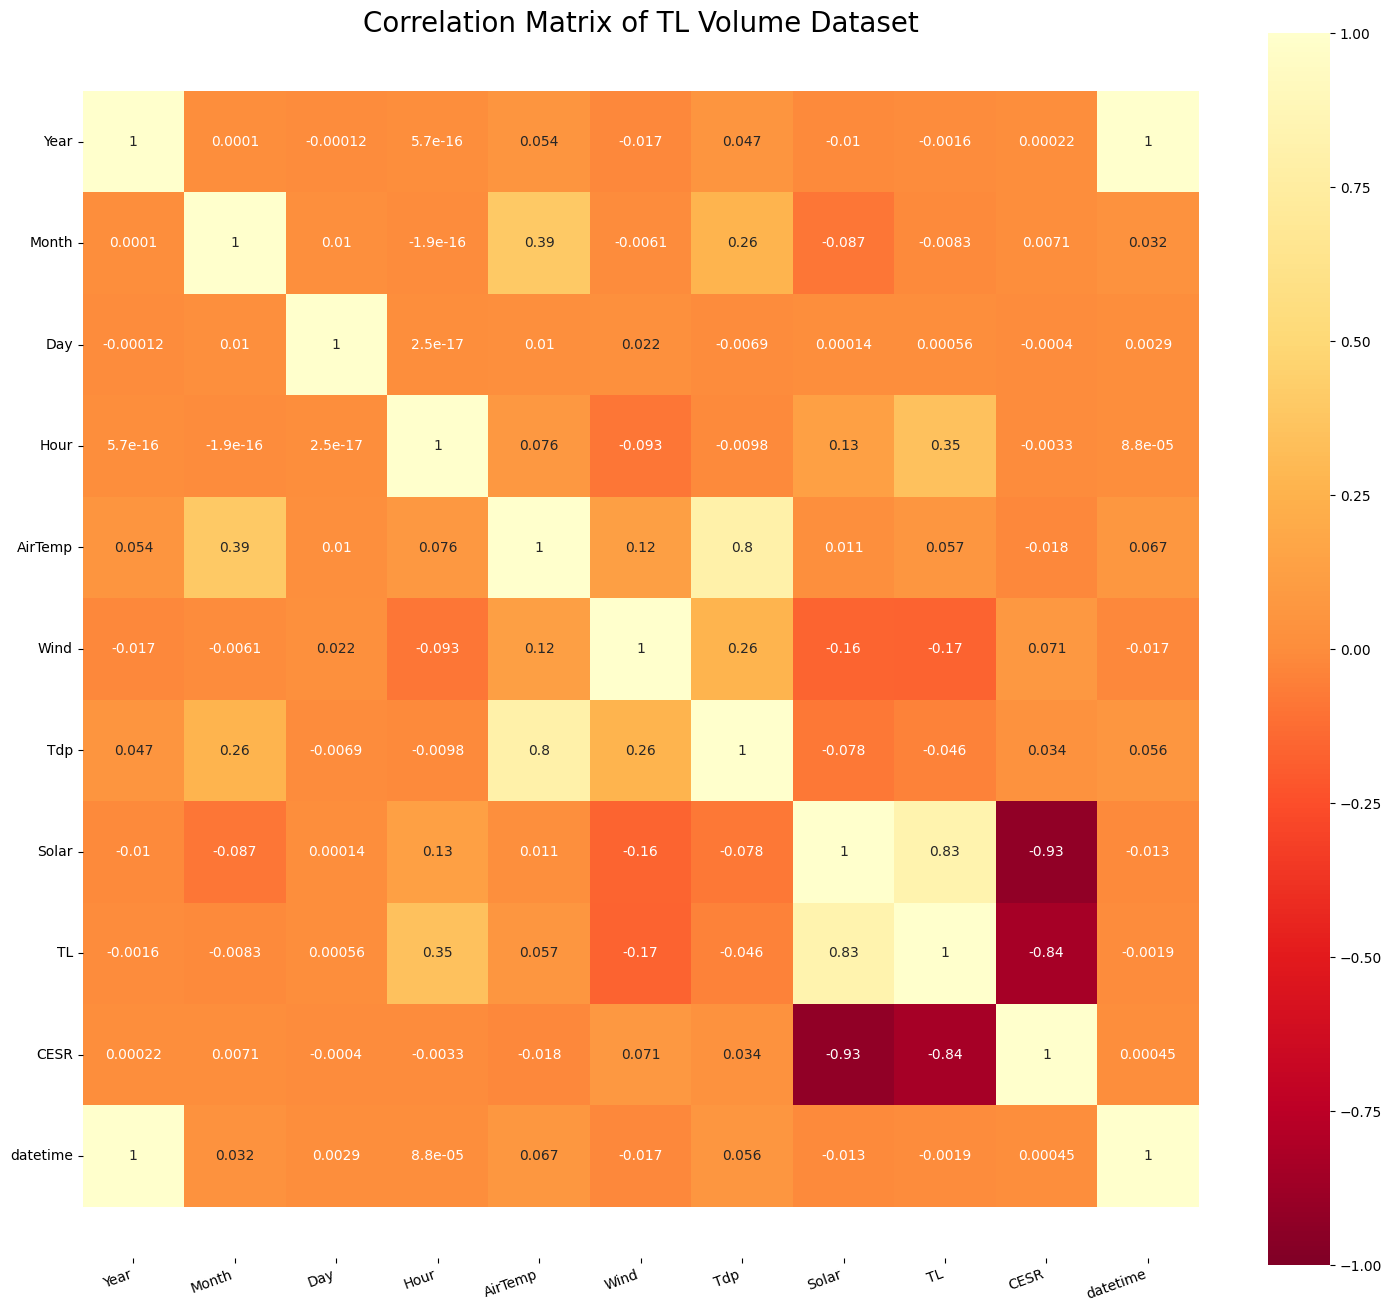

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271752 entries, 0 to 271751
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Year      271752 non-null  int64         
 1   Month     271752 non-null  int64         
 2   Day       271752 non-null  int64         
 3   Hour      271752 non-null  int64         
 4   AirTemp   271752 non-null  float64       
 5   Wind      271752 non-null  float64       
 6   Tdp       271752 non-null  float64       
 7   Solar     271752 non-null  float64       
 8   TL        271752 non-null  float64       
 9   CESR      271752 non-null  float64       
 10  datetime  271752 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 22.8 MB

The number of train set 217401
The number of test set 54351



In [4]:
# b. ACF/PACF of the dependent variable.
lags = 100
ACF_PACF_Plot(tl,lags,'TL Volume')

# c. Correlation Matrix with seaborn heatmap and Pearson's correlation coefficient
corr = df.corr()
plt.figure(figsize=(18,16))
ax = sns.heatmap(corr,vmin=-1, vmax=1, center=0, cmap='YlOrRd_r',square=True,annot=True)
bottom,top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=360)
ax.set_title('Correlation Matrix of TL Volume Dataset', fontsize=20)
plt.show()

# d. Check if the dataset have missing data or NAN.
df.info()
print()

# e. Split the dependent variable into train set (80%) and test set (20%)
train, test = train_test_split(tl_series, test_size=0.2, shuffle=False)
print('The number of train set', train.shape[0])
print('The number of test set', test.shape[0])
print()


# ======================= Stationarity ================================================================================================== #
The ADF test of TL:
ADF Statistic: -43.538076
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567



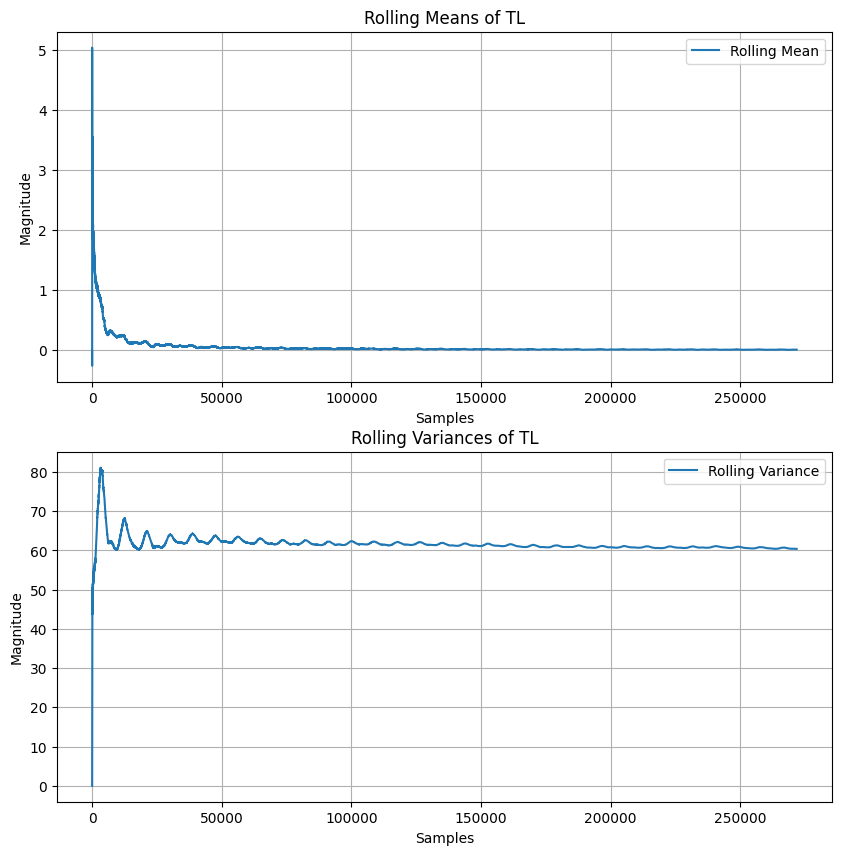

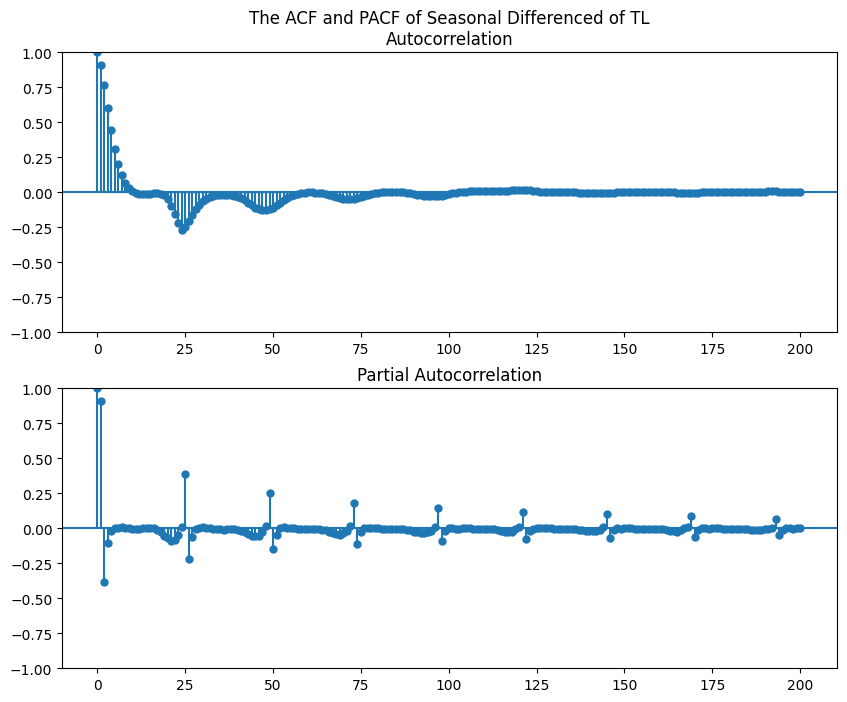

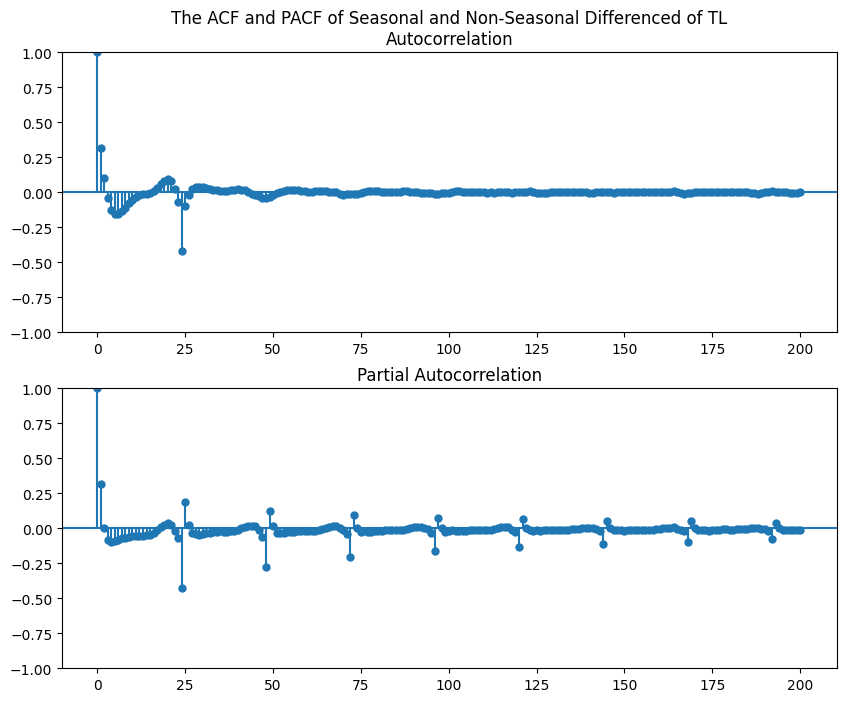

The ADF test of Differenced TL :
ADF Statistic: -101.013937
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567



In [5]:
print('# ======================= Stationarity ================================================================================================== #')
# ADF Test of raw dataset
ADF_Cal(tl,'TL')
print()

# Plot rolling mean and rolling variance of raw dataset
Rolling_Mean_Var_Plot(tl,'TL')

# Apply the seasonal differencing
traffic_diff = difference(tl, interval=24)     # seasonal differencing 24hr
# Plot ACF/PACF of seasonal differenced dataset
ACF_PACF_Plot(traffic_diff,lags*2,'Seasonal Differenced of TL')
# Apply the non-seasonal differencing
traffic_diff = difference(traffic_diff, interval=1)   # 1st order non-seasonal differencing
# Plot ACF/PACF of non-seasonal differenced dataset
ACF_PACF_Plot(traffic_diff,lags*2,'Seasonal and Non-Seasonal Differenced of TL')

# ADF Test of differenced dataset
ADF_Cal(traffic_diff,'Differenced TL ')
print()


# ======================= ARMA and ARIMA and SARIMA ========================================================================================== #
          1         2          3         4         5          6         7   \
0   0.481405  0.038333  -0.095071 -0.102969 -0.101618  -0.090891 -0.076609   
1   0.542579  1.230532  -0.136213 -0.010139 -0.010470  -0.005949  0.000000   
2   0.254385 -0.637419  -0.096574  0.116660 -0.005302  -0.005421 -0.040818   
3  -1.076542 -0.695925  -0.320647  0.061772 -0.064181  -0.001882 -0.001650   
4   2.305616 -0.741453  -0.009582 -0.094976 -0.044066   0.034848 -0.038522   
5   1.295296 -0.739503   7.120393 -0.083696 -0.067606  -0.915846 -0.707452   
6   1.045121 -0.706717   0.652072 -0.766831 -0.673286   0.508846 -0.198937   
7   0.914518 -0.663963  -0.102912  3.906207  4.518835   0.099370 -0.577240   
8   0.823790 -0.672538 -29.282358  4.631703  3.856419  21.222945 -0.550769   
9   0.742797 -0.209302   0.879949  0.103465  0.119904  -0.051484 -0.046389 

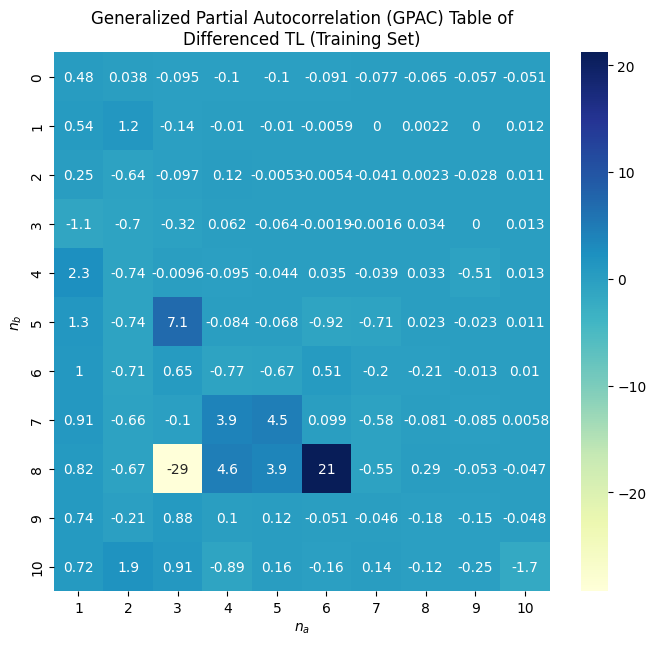

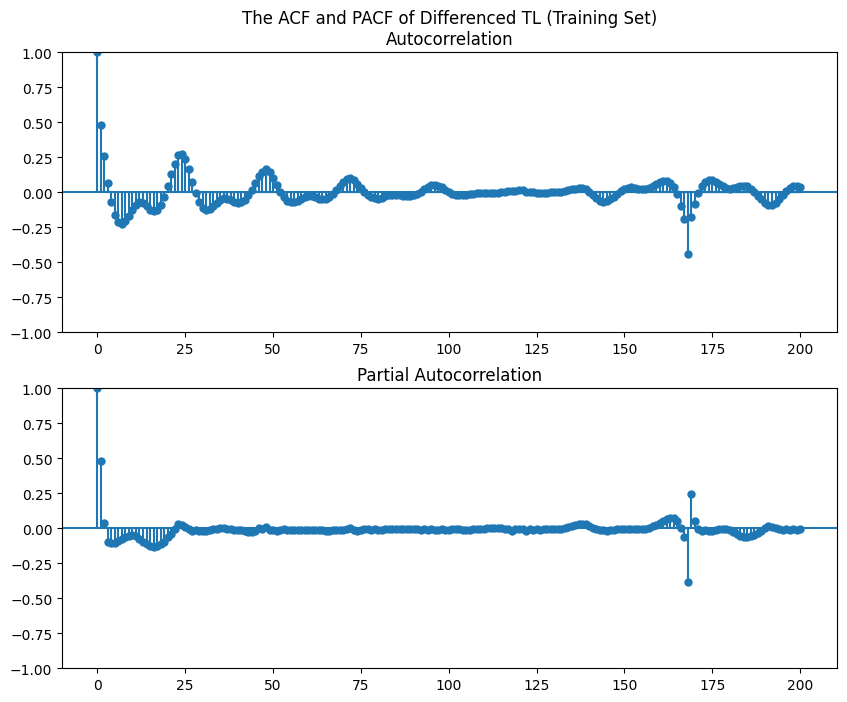

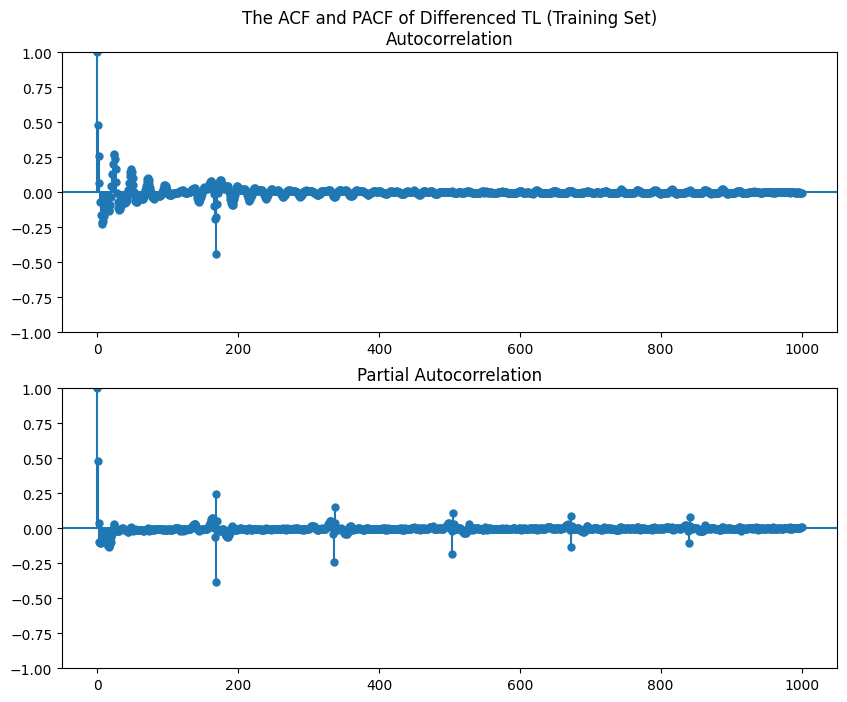

In [6]:
print('# ======================= ARMA and ARIMA and SARIMA ========================================================================================== #')
# Split differenced dataset (stationary) into 80% training set and 20% testing set
train_diff, test_diff = train_test_split(traffic_diff, test_size=0.2, shuffle=False)

# a) Implement differenced train (stationary) to GPAC table to estimate the order of SARIMA model (non-seasonal differencing + seasonal differencing)  (Not useful for S=168)
ry_SARIMA_train = autocorr_values(train_diff,lags)
Cal_GPAC(ry_SARIMA_train,10,10,'Differenced TL (Training Set)')

# b) Plot ACF of differenced dataset (stationary)
ACF_PACF_Plot(train_diff,lags*2,'Differenced TL (Training Set)')                       # lags = 200
ACF_PACF_Plot(train_diff,lags*10,'Differenced TL (Training Set)')    # lags = 1000
# Estimated Model from ACF/PACF is ARIMA(0,1,3)xARIMA(0,1,1)_s168, which is equalivalent to ARMA(0,171)